In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.environments import Env
from src.agents import AgentEWA, AgentQ
import src.helpers as F 

import pymdp
from pymdp import utils

sns.set_style('whitegrid')

In [2]:
# env = Env(payoff_structure=(0.6, 0.3, 0.1))
env = Env(payoff_structure=(0.9,0.1,0.5))

EPISODES = 2000
RUN_LENGTH = 1000

""" arrays to hold returns """
# Q agents
returns_Q = np.zeros([EPISODES, RUN_LENGTH])
returns_Q_greedy = np.zeros([EPISODES, RUN_LENGTH])
returns_Q_smart = np.zeros([EPISODES, RUN_LENGTH])
returns_Q_social = np.zeros([EPISODES, RUN_LENGTH])

# EWA agents
returns_EWA = np.zeros([EPISODES, RUN_LENGTH])
returns_EWA_asoc = np.zeros([EPISODES, RUN_LENGTH])


for episode in range(EPISODES):

    agentQ = AgentQ('A')
    agentEWA = AgentEWA('B', is_social=True)
    agentEWA_asoc = AgentEWA('B', sigma=0, is_social=False)
    agentQ_smart = AgentQ('C')
    agentQ_greedy = AgentQ("D", epsilon=0, is_social=False)
    agentQ_social = AgentQ("D", epsilon=0, is_social=True)


    env.reset()

    for i in range(RUN_LENGTH):
        actions_this_round = {}
        actions_last_round =  None if (i == 0) else env.history[-1] # TODO?

        if i % 250 == 0: 
            env.switch()
            agentQ_smart.reset_Qvals()

        for agent in (agentQ, agentQ_greedy, agentQ_smart, agentEWA, agentEWA_asoc, agentQ_social):
            choice = agent.choose_action(context=actions_last_round)
            actions_this_round[agent.id] = choice
            reward, is_optimal = env.return_rewards(choice)
            agent.update_state(reward, is_optimal)
            agent.update_Qvals(choice, reward)

        env.history.append(actions_this_round)
    

    returns_Q[episode, :] = agentQ.payoffs
    returns_Q_greedy[episode, :] = agentQ_greedy.payoffs
    returns_Q_smart[episode, :] = agentQ_smart.payoffs
    returns_Q_social[episode, :] = agentQ_social.payoffs
    returns_EWA[episode, :] = agentEWA.payoffs
    returns_EWA_asoc[episode, :] = agentEWA_asoc.payoffs



In [3]:
for ret in (returns_Q, returns_Q_greedy, returns_Q_smart, returns_Q_social, returns_EWA, returns_EWA_asoc):
    print(np.mean(ret))

0.4990121115840022
0.4933023948585412
0.6965431548596691
0.6456640917413438
0.5607257290946235
0.5053875737067823


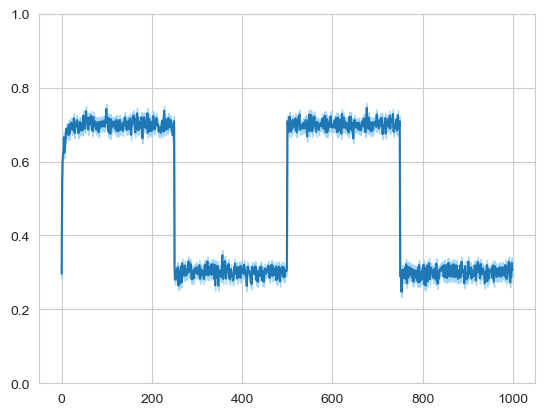

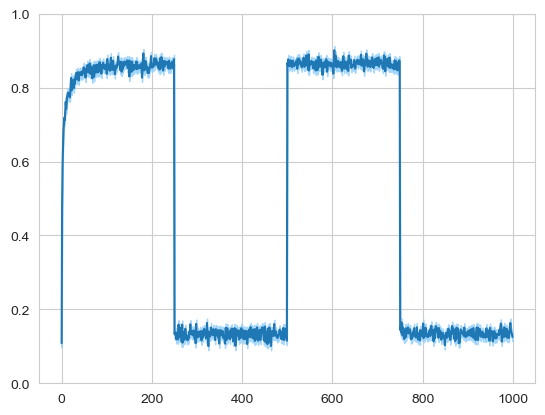

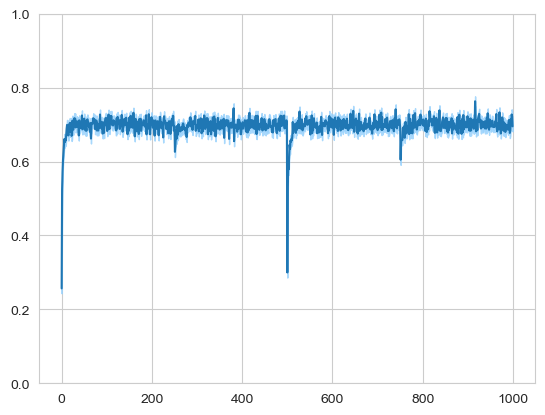

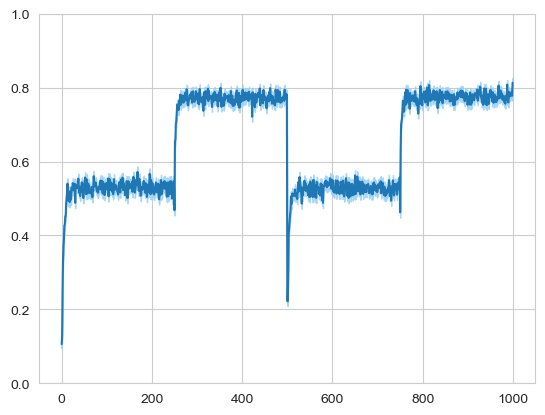

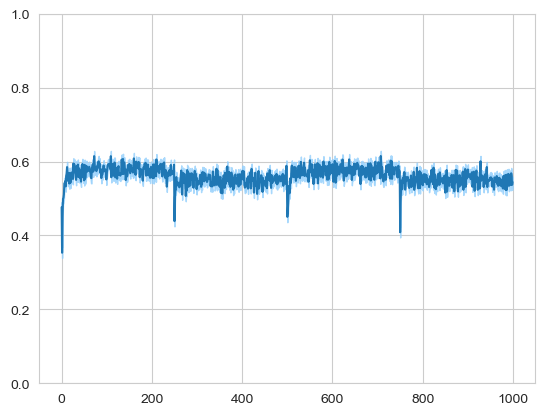

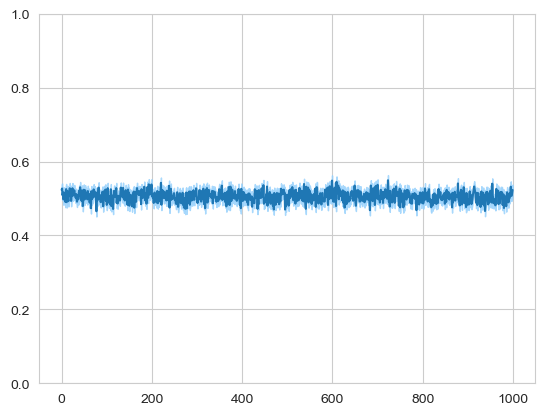

In [4]:
F.plot_returns(returns_Q)
F.plot_returns(returns_Q_greedy)
F.plot_returns(returns_Q_smart)
F.plot_returns(returns_Q_social)
F.plot_returns(returns_EWA)
F.plot_returns(returns_EWA_asoc)

### Q-learning

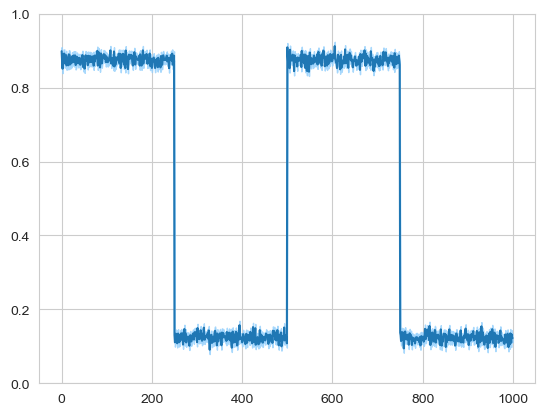

In [4]:
F.plot_returns(returns_Q)

### EWA

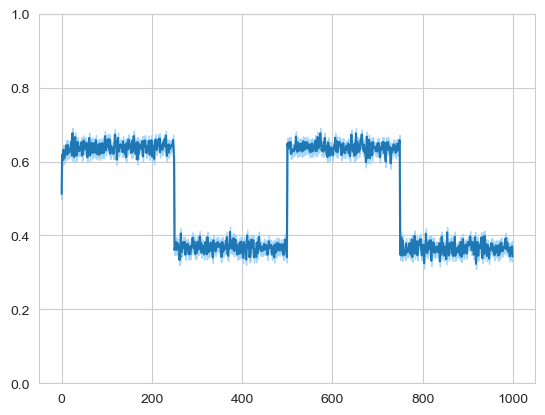

In [5]:
F.plot_returns(returns_EWA)


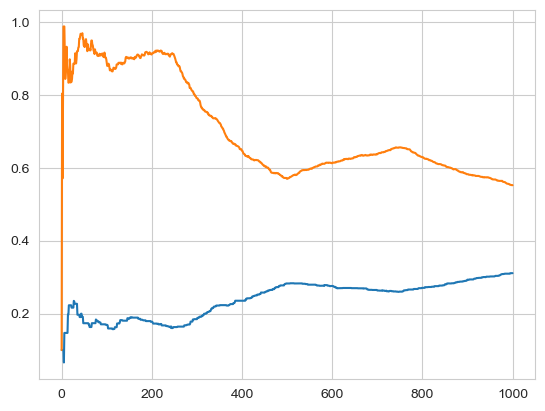

In [5]:
plt.plot(agentQ.Q_vals)

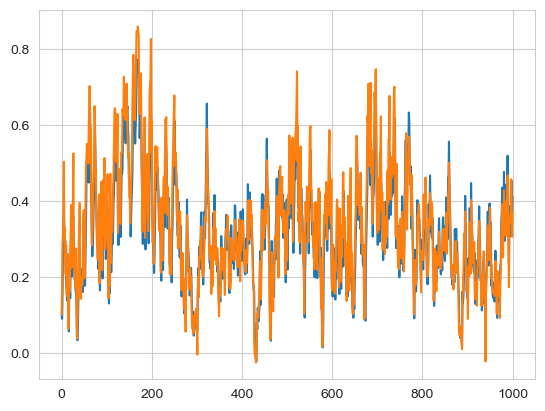

In [6]:
plt.plot(agentEWA.Q_vals)

In [ ]:
print(np.mean(agentEWA1.correct), np.mean(agentQ1.correct) )

0.501 0.476


446.84698492019896 441.1802904727145


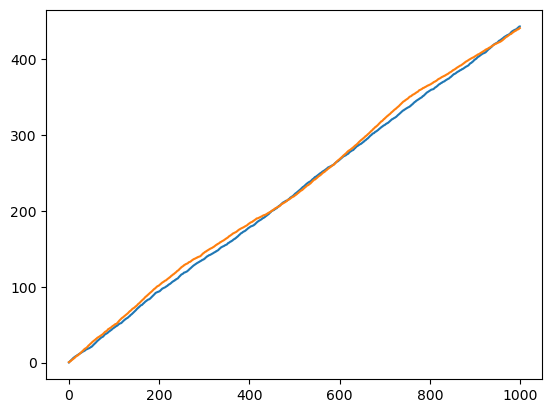

In [ ]:
# plt.plot(np.cumsum(agentEWA1.payoffs))
plt.plot(np.cumsum(agentEWA2.payoffs))
plt.plot(np.cumsum(agentQ1.payoffs))

print(np.sum(agentEWA1.payoffs),np.sum(agentQ1.payoffs))